In [429]:
from model import *

import time
import sys
#!{sys.executable} -m pip install [arg]

import multiprocessing as mp

import random

import torch
from torch_geometric.data import Data
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree

import networkx as nx

import numpy as np
from itertools import permutations
from sklearn.metrics import euclidean_distances


import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({"font.size" : 15,
                     "figure.dpi" : 100, 
                     "grid.alpha" : 0.3, 
                     "axes.grid": True, 
                     "axes.axisbelow" : True,
                     "figure.figsize":(8,6),
                     "mathtext.fontset":"cm",
                     "xtick.labelsize": 14,
                     "ytick.labelsize": 14,
                     "axes.labelsize": 16, 
                     "legend.fontsize": 13.5})

USE_TEX = False
if USE_TEX:
    plt.rc("text", usetex=True)
    plt.rc("text.latex", preamble=r"""
     \usepackage{times}
     \usepackage{mathptmx}""")
else:
    plt.rc("text", usetex=False)
plt.rc("font", family="serif")

# Example

In [3]:
edge_index = torch.tensor([[0, 1, 1, 2],
                           [1, 0, 2, 1]], dtype=torch.long)

x = torch.tensor([[-1], [0], [1]], dtype=torch.float)

In [4]:
data = Data(x=x, edge_index=edge_index)

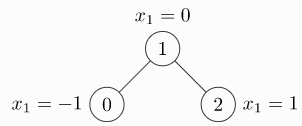

# Model

`propagate()` internally calls `message()`, `aggregate()` and `update()`

In [5]:
class Graph(MessagePassing):
    
    
    def __init__(self, N, w_init):
        """
        N      : number of agent nodes
        w_init : initial wealth of agents
        """
        # construct edges
        pairs = list(permutations(range(N), 2))    
        edge_index = torch.tensor(pairs, dtype=torch.long).t().contiguous()

        # initial wealth levels
        x = torch.tensor([[w_init]*N], dtype=torch.float).t()

        # construct Data object
        # weights all equal since wealth distribution is uniform initially
        self.data = Data(x=x, edge_index=edge_index, edge_weights=torch.ones(edge_index.shape))
        
        
    def forward(self):
        pass
    

    def message(self):
        pass

# 1) Construct network

In [220]:
def build_graph(n=100, m=3, p=0.5):
    G = nx.powerlaw_cluster_graph(n=n, m=m, p=p) 
    assert nx.is_connected(G)
    return G


def get_adjacency(G):
    return dict((n, set(nbrdict.keys())) for n, nbrdict in G.adjacency())

# 2) Define groups

In [285]:
def get_communities(G):
    return list(nx.community.label_propagation_communities(G))


def get_node_community_map(communities):
    node_community_map = {}
    for i,c in enumerate(communities):
        for node in c:
            node_community_map[node] = i
    return node_community_map


def get_community_membership(adjacency, node_community_map):
    membership = {i:set() for i in node_community_map}
    for i, neighbours in adjacency.items():
        for n in neighbours:
            membership[i].add(node_community_map[n])
        membership[i].add(node_community_map[i])
    return membership

# 3) Generate projects

In [320]:
def generate_projects(N, left_0=0.5, right_0=0.8, left_1=1.6, right_1=3.2):
    """
    Generate N gambles with 2 outcomes.
    """
    assert (left_0+left_1) / 2 > 1
    
    left  = np.random.uniform(left_0, right_0, N)
    right = np.random.uniform(left_1, right_1, N)
    projects = {i:(left[i],right[i]) for i in range(N)}
                
    return projects


def get_project_return(P):
    return np.random.uniform(P[0], P[1])

# 4) Maximize expected utility

In [223]:
def utility(x, w, project_uniform_bounds, safe_return, A, gamma):
    """
    Compute expected utility.
    Args:
        x : (3,) array containing [consumption_proportion, risky_invest_proportion, safe_invest_proportion]
        w : wealth level of agent
        project_uniform_bounds : tuple denoting left and right bounds of uniform random risky project return
        safe_return : amount of safe return
        A : utility function parameter
        gamma : utility function parameter
    Returns:
        best utility
    """
    r0, r1 = project_uniform_bounds
    c_prop, r_prop, s_prop = x
    
    # utility from consumption
    consumption_utility = U(w*c_prop, A=A, gamma=gamma)
    
    # best possible expected project utility
    project_utility = (1/(r1-r0)) * integrate.quad(lambda r: V(w*r_prop*r + w*s_prop*safe_return, gamma=gamma),
                                                   r0, r1)[0]
    
    return - (consumption_utility + project_utility)

In [161]:
default_gamma = 2.1
default_A = 1.2

bounds = ((0.0,1.0),(0.0,1.0),(0.0,1.0),)
cons = ({'type': 'eq', 'fun': lambda x:  1 - sum(x)})

project_bounds = (0.5, 2.5)
safe_return = 1.1

w = 1

/Users/charlesdupont/Desktop/poverty-trap/model.py:14: RuntimeWarning: divide by zero encountered in double_scalars
  return A*x**(1-gamma) / (1-gamma)
/Users/charlesdupont/Desktop/poverty-trap/model.py:21: RuntimeWarning: divide by zero encountered in double_scalars
  return x**(1-gamma) / (1-gamma)


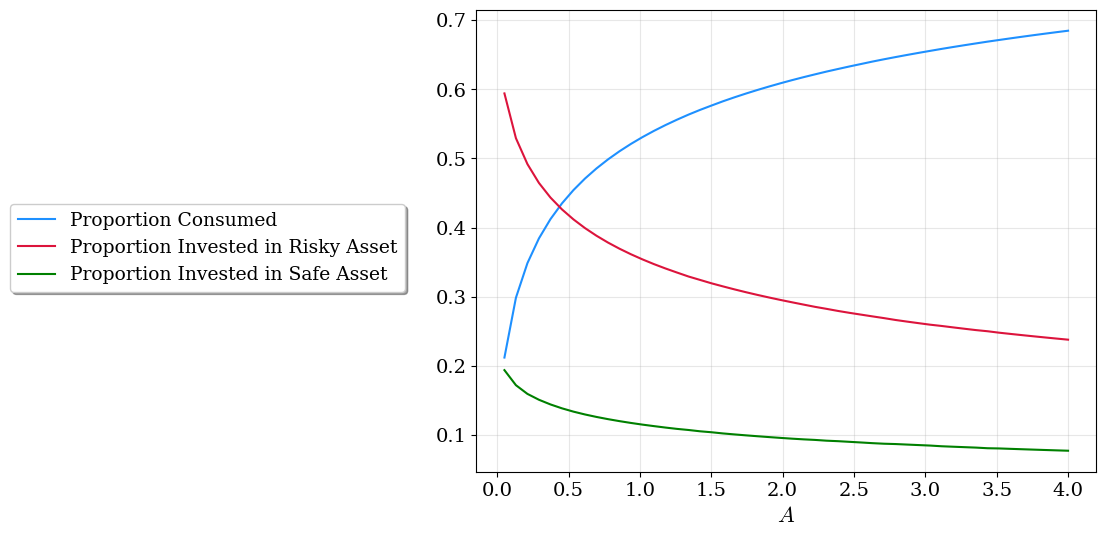

In [162]:
c = []
r = []
s = []

A_vals = np.linspace(0.05, 4, 50)
for a in A_vals:
    res = minimize(utility, x0=0.5, bounds=bounds, constraints=[cons], 
                      args=(w, project_bounds, safe_return, a, default_gamma), method='SLSQP')

    params = res.x
    c.append(params[0])
    r.append(params[1])
    s.append(params[2])
    u.append(res.fun)    
    
plt.plot(A_vals, c, color="dodgerblue", label="Proportion Consumed")
plt.plot(A_vals, r, color="crimson", label="Proportion Invested in Risky Asset")
plt.plot(A_vals, s, color="green", label="Proportion Invested in Safe Asset")
plt.legend(bbox_to_anchor=(-0.1,0.6), shadow=True)
plt.xlabel(r"$A$")
plt.show()

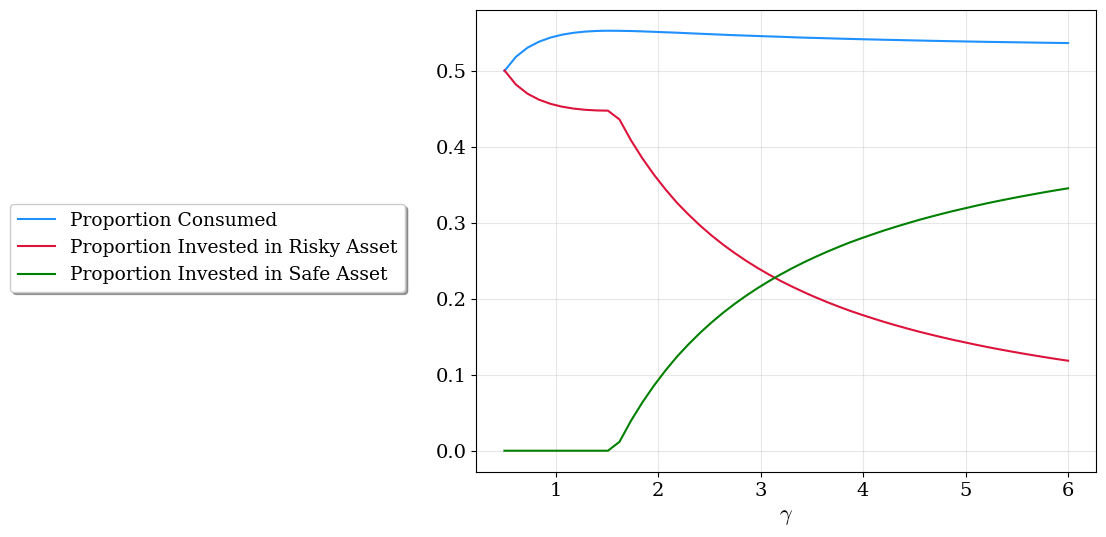

In [163]:
c = []
r = []
s = []

G_vals = np.linspace(0.5, 6, 50)
for g in G_vals:
    res = minimize(utility, x0=0.5, bounds=bounds, constraints=[cons], 
                      args=(w, project_bounds, safe_return, default_A, g), method='SLSQP').x
    c.append(res[0])
    r.append(res[1])
    s.append(res[2])
    
plt.plot(G_vals, c, color="dodgerblue", label="Proportion Consumed")
plt.plot(G_vals, r, color="crimson", label="Proportion Invested in Risky Asset")
plt.plot(G_vals, s, color="green", label="Proportion Invested in Safe Asset")
plt.legend(bbox_to_anchor=(-0.1,0.6), shadow=True)
plt.xlabel(r"$\gamma$")
plt.show()

# 5) Simulation

In [724]:
class Agent:
    
    
    def __init__(self, id, w, gamma, communities):
        
        self.id          = id
        self.gamma       = gamma
        self.communities = list(communities)
        W[id] = w
        
        
    def optimize(self, pid):
        
        bounds = ((0.0,1.0),(0.0,1.0),(0.0,1.0),)
        cons = ({'type': 'eq', 'fun': lambda x:  1 - sum(x)})
    
        # find optimal consumption, risky investment, and safe investment proportions
        c, r, s = minimize(utility, x0=[0.33, 0.33, 0.34], bounds=bounds, constraints=[cons], 
                           args=(W[self.id], PROJECTS[pid], SAFE_RETURN, DEFAULT_A, self.gamma), 
                           method='SLSQP').x
        C[self.id] = c
        R[self.id] = r
        S[self.id] = s
        PID[self.id] = pid

In [562]:
NUM_AGENTS = 500

G = build_graph(n=NUM_AGENTS, m=2)
adjacency = get_adjacency(G)

communities = get_communities(G)
print(f"{len(communities)} communities")

node_community_map = get_node_community_map(communities)
community_membership = get_community_membership(adjacency, node_community_map)

91 communities


0it [00:00, ?it/s]
100%|██████████| 20/20 [00:41<00:00,  2.06s/it]


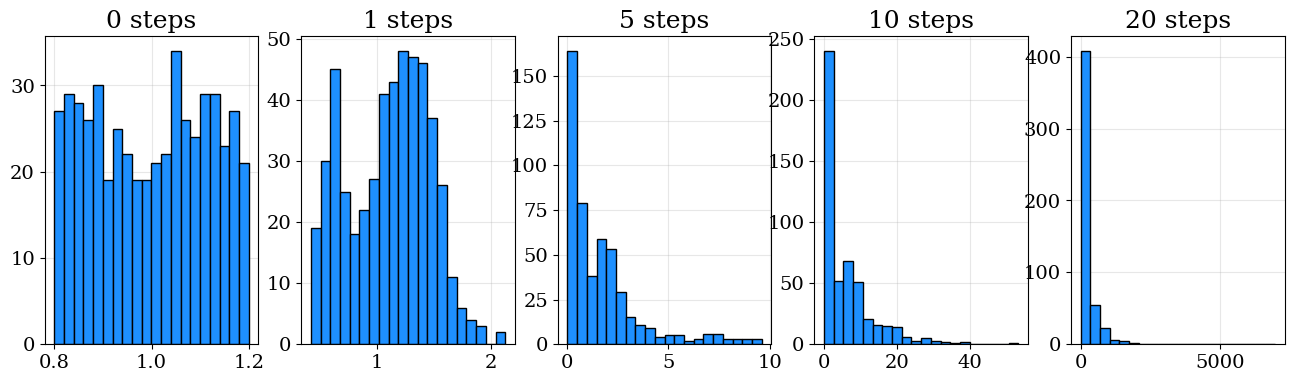

In [604]:
STEPS        = 20
SAFE_RETURN  = 1.1
DEFAULT_A    = 1.2
W_INIT       = 1.0
PROJECT_COST = 3.0


fig, axs = plt.subplots(1, 5, figsize=(16,4))


for idx, STEPS in enumerate([0, 1, 5, 10, 20]):

    PROJECTS = generate_projects(len(communities))
    GAMMAS   = np.random.uniform(0.5, 5.0, NUM_AGENTS)

    W = np.zeros((NUM_AGENTS))
    C = np.zeros((NUM_AGENTS))
    R = np.zeros((NUM_AGENTS))
    S = np.zeros((NUM_AGENTS))
    PID = np.zeros((NUM_AGENTS), dtype=int)

    AGENTS = []
    for i in range(NUM_AGENTS):
        AGENTS.append(Agent(i, np.random.uniform(0.8, 1.2), GAMMAS[i], community_membership[i]))

    project_choices = [np.random.choice(a.communities, STEPS) for a in AGENTS]

    for step in tqdm(range(STEPS)):

        project_contributions = np.zeros((len(PROJECTS)))

        # all agents perform optimization step and we sum up project contributions
        for a in AGENTS:
            a.optimize(project_choices[a.id][step])
            project_contributions[PID[a.id]] += W[a.id]*R[a.id]

        # run projects
        project_returns = np.zeros((len(PROJECTS)))
        for P in PROJECTS:
            if project_contributions[P] >= PROJECT_COST:
                project_returns[P] = get_project_return(PROJECTS[P])

        # update agent wealth
        safe_return = W * S * SAFE_RETURN
        W = W - W*R + W*R*project_returns[PID] + safe_return

    axs[idx].hist(W, color="dodgerblue", edgecolor="k", bins=20)
    axs[idx].set_title(f"{STEPS} steps")

In [825]:
STEPS        = 20
SAFE_RETURN  = 1.1
DEFAULT_A    = 1.2

PROJECT_COST = 5.0

P_SUCCESS = np.zeros((len(communities)))

PROJECTS = generate_projects(len(communities))
GAMMAS   = np.random.uniform(0.5, 5.0, NUM_AGENTS)

community_wealths = []
wealths = []

W = np.zeros((NUM_AGENTS))
C = np.zeros((NUM_AGENTS))
R = np.zeros((NUM_AGENTS))
S = np.zeros((NUM_AGENTS))
PID = np.zeros((NUM_AGENTS), dtype=int)

AGENTS = []
for i in range(NUM_AGENTS):
    AGENTS.append(Agent(i, np.random.uniform(0.8, 1.2), GAMMAS[i], community_membership[i]))
    

project_choices = [np.random.choice(a.communities, STEPS) for a in AGENTS]

for step in tqdm(range(STEPS)):
    
    wealths.append(np.copy(W))

    project_contributions = np.zeros((len(PROJECTS)))

    # all agents perform optimization step and we sum up project contributions
    for a in AGENTS:
        a.optimize(project_choices[a.id][step])
        project_contributions[PID[a.id]] += W[a.id]*R[a.id]

    # run projects
    project_returns = np.zeros((len(PROJECTS)))
    for P in PROJECTS:
        if project_contributions[P] >= PROJECT_COST:
            project_returns[P] = get_project_return(PROJECTS[P])
            P_SUCCESS[P] += 1

    # update agent wealth
    W = W - W*R + W*R*project_returns[PID] +  W*S*SAFE_RETURN
    
    COMMUNITY_WEALTH = np.zeros((len(communities)))
    for i,c in enumerate(communities):
        for agent in c:
            COMMUNITY_WEALTH[i] += W[agent]
    
    community_wealths.append(np.copy(COMMUNITY_WEALTH))

  0%|          | 0/20 [00:00<?, ?it/s]/Users/charlesdupont/Desktop/poverty-trap/model.py:21: RuntimeWarning: divide by zero encountered in double_scalars
  return x**(1-gamma) / (1-gamma)
 30%|███       | 6/20 [00:12<00:30,  2.15s/it]/Users/charlesdupont/Desktop/poverty-trap/model.py:14: RuntimeWarning: divide by zero encountered in double_scalars
  return A*x**(1-gamma) / (1-gamma)
100%|██████████| 20/20 [00:39<00:00,  1.98s/it]


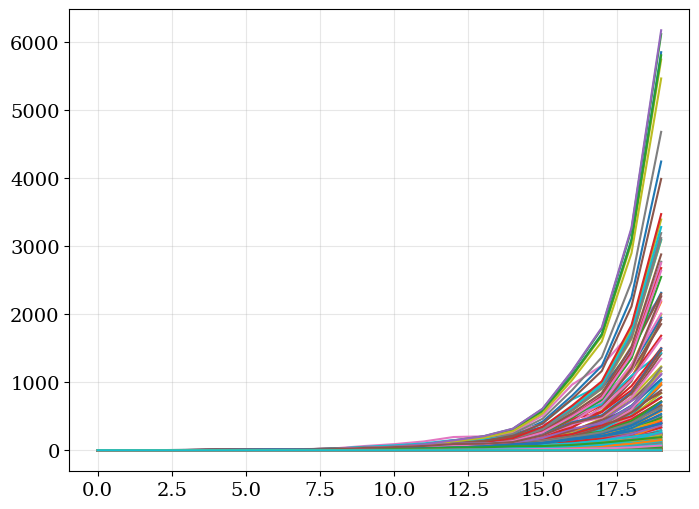

In [826]:
for a in range(NUM_AGENTS):
    plt.plot([wealths[t][a] for t in range(len(wealths))] )

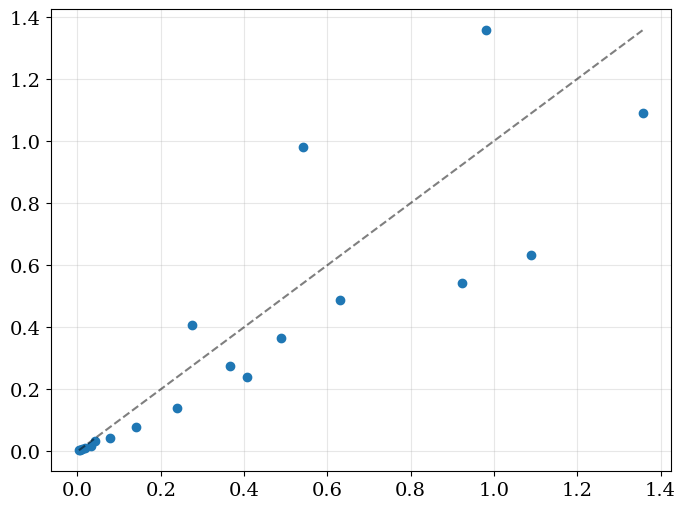

In [828]:
a = 0

x = []
y = []
for t in range(len(wealths)-1):
    x.append(wealths[t][a])
    y.append(wealths[t+1][a])

plt.scatter(x,y)

plt.plot(np.linspace(min(x), max(x)), np.linspace(min(x), max(x)), color="k", linestyle="dashed", alpha=0.5)
plt.show()

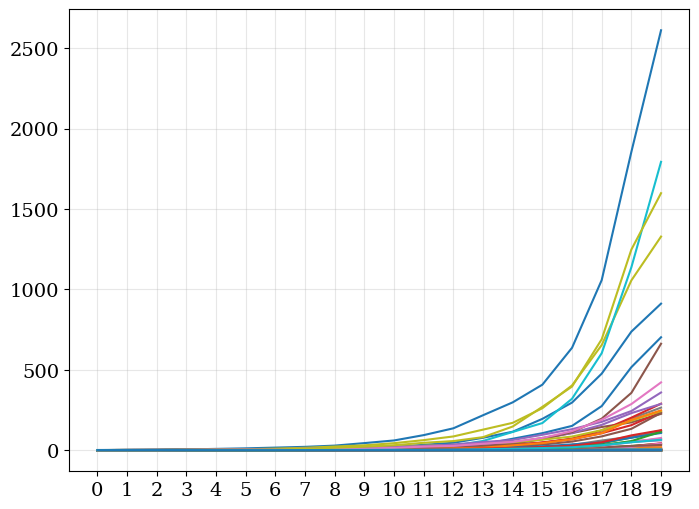

In [850]:
for c in range(len(communities)):
    plt.plot( [community_wealths[t][c]/len(communities[c]) for t in range(len(community_wealths))] )
    
plt.xticks(np.linspace(0, 19, 20))
plt.show()